In [2]:
from copy import deepcopy, copy
import os
import pathlib
from random import shuffle

import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ChainDataset, ConcatDataset
from livelossplot import PlotLosses

from augmentations import SemitoneShift
from dataset import MirexDataset, MirexFameDataset
from models.cnn import model

%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 5)

In [3]:
beatles_dataset = MirexFameDataset(audio_dir='data/beatles/mp3s-32k/',
                                   ann_dir='data/beatles/chordlabs/',
                                   window_size=8192, hop_length=4096, context_size=7)
queen_dataset = MirexFameDataset(audio_dir='data/queen/mp3/',
                                 ann_dir='data/queen/chordlabs/',
                                 window_size=8192, hop_length=4096, context_size=7)
dataset = ConcatDataset([beatles_dataset, queen_dataset])
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

augmented = SemitoneShift(train_dataset, p=1.0, max_shift=4, bins_per_semitone=2)
dataset = ConcatDataset([train_dataset, augmented])
loader_train = DataLoader(dataset, shuffle=True, num_workers=0, batch_size=32)
loader_val = DataLoader(test_dataset, shuffle=True, num_workers=0, batch_size=32)

dataloaders = {
    "train": loader_train,
    "val": loader_val
}

In [4]:
def save_checkpoint(state_dict, is_best, filename='etd_best_model.pt'):
    if is_best:
        torch.save(state_dict, f'results/{filename}')

In [5]:
def train_model(model, optimizer, dataloaders, device, epochs=1):
    liveloss = PlotLosses()
    model = model.to(device=device)
    
    best_acc = 0
    for e in range(epochs):
        logs = {}
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # put model to training mode
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
        
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device=device, dtype=torch.float32)
                labels = labels.to(device=device, dtype=torch.long)
                labels = torch.argmax(labels, 1)
                if phase == 'train':
                    # Zero out all of the gradients for the variables which the optimizer
                    # will update.
                    optimizer.zero_grad()
            
                scores = model(inputs)
                scores = scores.squeeze(3).squeeze(2)                
                loss = F.cross_entropy(scores, labels)
                
                _, preds = torch.max(scores, 1)
                running_corrects += torch.sum(preds == labels)

        
                if phase == 'train':        
                    # This is the backwards pass: compute the gradient of the loss with
                    # respect to each  parameter of the model.
                    loss.backward()
        
                    # Actually update the parameters of the model using the gradients
                    # computed by the backwards pass.
                    optimizer.step()
            
                running_loss += loss.detach() * inputs.size(0)
        
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
            prefix = ''
            if phase == 'val':
                prefix = 'val_'
                is_best = epoch_acc > best_acc
                best_acc = max(epoch_acc, best_acc)
                save_checkpoint(model.state_dict(), is_best)
            
            logs[prefix + ' log loss'] = epoch_loss.item()
            logs[prefix + 'accuracy'] = epoch_acc.item()
        
        liveloss.update(logs)
        liveloss.send()

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

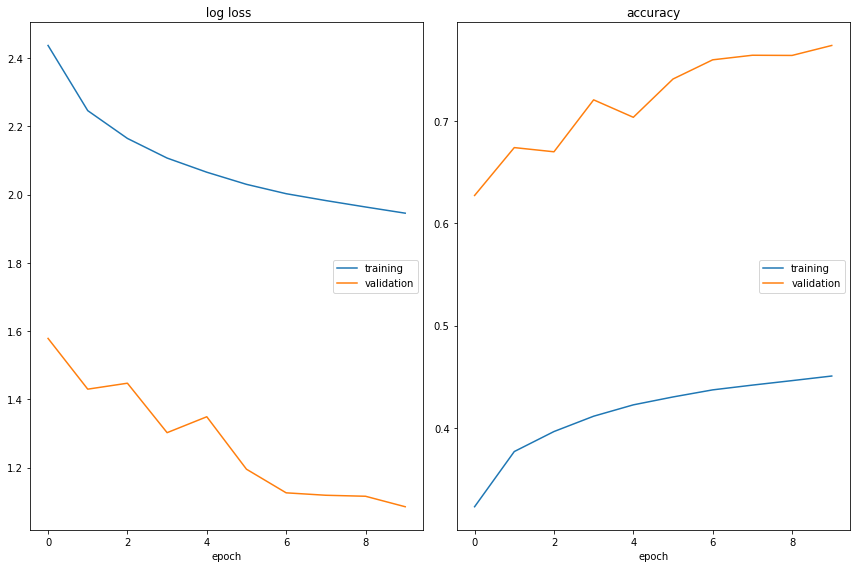

 log loss
	training         	 (min:    1.945, max:    2.437, cur:    1.945)
	validation       	 (min:    1.086, max:    1.579, cur:    1.086)
accuracy
	training         	 (min:    0.323, max:    0.451, cur:    0.451)
	validation       	 (min:    0.627, max:    0.774, cur:    0.774)


In [7]:
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=1e-7)

train_model(model, optimizer, dataloaders, device, 10)

In [ ]:
# Eliminate overfitting:
# - shifts the spectrogram up or down in discrete semitone steps by a maximum of 4 semitones
# This manipulation does not preserve the label, which we thus adjust accordingly
# -  The second operation emulates a slight detuning by shifting the spectrogram
# by fractions of up to 0.4 of a semitone
# - Try smaller sets of features
# - Try increasing lambda
# Check mir_eval in chordrec
# Tool to print inference result of the model in time/chord form